In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC
import pandas as pd
import optuna
from optuna.integration import SkoptSampler
from copy import deepcopy
from sklearn.metrics import balanced_accuracy_score
import joblib
import pickle
from tqdm import tqdm

# --------------------------------------------------
# 读取 data_long.xlsx（包含 Subject, a, v, t, z, label）
# --------------------------------------------------
df = pd.read_excel('data_long_zscore_label.xlsx')

# 确认字段存在
required_cols = ['Subject', 'a', 'v', 't', 'z', 'label']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"缺少必需的列: {col}")

# 定义不同特征组合（"all": 保留所有；"no_a": 不含 a；依次类推）
feature_sets = {
    'all': ['a', 'v', 't', 'z'],
    'no_a': ['v', 't', 'z'],
    'no_v': ['a', 't', 'z'],
    'no_t': ['a', 'v', 'z'],
    'no_z': ['a', 'v', 't']
}

# --------------------------------------------------
# 定义 Optuna 优化函数（优化目标改为在内层验证集上的性能）
# --------------------------------------------------
def optuna_opti(trial, x_train, y_train, x_val, y_val):
    params = {'random_state': 0, 'probability': True}
    params['kernel'] = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    params['C'] = trial.suggest_float('C', 0.001, 0.01)
    params['gamma'] = trial.suggest_categorical('gamma', ['scale', 'auto'])
    params['class_weight'] = trial.suggest_categorical('class_weight', ['balanced', None])
    clf = SVC(**params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_val)
    val_acc = balanced_accuracy_score(y_val, y_pred)
    return val_acc

# --------------------------------------------------
# 主循环：针对每个特征组合，训练并保存结果
# --------------------------------------------------
epoch = 1 # 外层随机拆分次数
np.random.seed(42)
random_numbers = np.random.rand(100)
random_numbers = [int(x * 1000) for x in random_numbers]

for feature_set_name, feature_list in feature_sets.items():
    # 构建特征矩阵 X 和 标签 y
    X = df[feature_list].copy()
    y = df['label'].to_numpy()

    # 初始化存储结果的列表和全局最佳项
    inner_metrics_list = []
    out_metrics_list = []
    hold_metrics_list = []
    hold_params_list = []
    global_best_item = {}
    global_best_item_list = []

    model_name = f"SVM_{feature_set_name}"

    # 针对当前特征组合，进行多次随机拆分与超参数搜索
    for _ in tqdm(range(epoch), desc=f"Processing {model_name}"):
        best_auc = 0
        best_params = {}

        # ===========================
        # 第一步：随机拆分训练集和保留集（holdout）
        # ===========================
        X_train_df, X_holdout_df, y_train, y_holdout = train_test_split(
            X, y,
            test_size=0.3,
            stratify=y,
            random_state=random_numbers[_]
        )
        train_indices = X_train_df.index
        test_indices = X_holdout_df.index

        # 将 Train Data 和 Test Data（仅 Subject 信息）写入 Excel
        with pd.ExcelWriter(f'./split_csv/{model_name}_indices_{_}.xlsx') as writer:
            train_meta = df[['Subject']].loc[train_indices].reset_index(drop=True)
            train_meta.to_excel(writer, sheet_name='Train Data', index=False)
            test_meta = df[['Subject']].loc[test_indices].reset_index(drop=True)
            test_meta.to_excel(writer, sheet_name='Test Data', index=False)

            temp1 = deepcopy(X_train_df)
            temp1['Y'] = y_train
            temp1.reset_index(drop=True, inplace=True)
            temp1.to_excel(writer, sheet_name='Hold Train', index=False)

            temp2 = deepcopy(X_holdout_df)
            temp2['Y'] = y_holdout
            temp2.reset_index(drop=True, inplace=True)
            temp2.to_excel(writer, sheet_name='Hold Test', index=False)

        # 转换为 numpy 数组，用于后续交叉验证
        X_train_np = X_train_df.to_numpy()
        X_holdout_np = X_holdout_df.to_numpy()

        # ===========================
        # 第二步：嵌套交叉验证（5 折外层，3 折内层），使用 Optuna 优化 SVM 超参数
        # ===========================
        outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        for outer_train_idx, outer_test_idx in outer_cv.split(X_train_np, y_train):
            X_train_outer = X_train_np[outer_train_idx]
            y_train_outer = y_train[outer_train_idx]
            X_test_outer = X_train_np[outer_test_idx]
            y_test_outer = y_train[outer_test_idx]

            for inner_train_idx, inner_test_idx in inner_cv.split(X_train_outer, y_train_outer):
                X_train_inner = X_train_outer[inner_train_idx]
                y_train_inner = y_train_outer[inner_train_idx]
                X_test_inner = X_train_outer[inner_test_idx]
                y_test_inner = y_train_outer[inner_test_idx]

                algo = SkoptSampler(
                    skopt_kwargs={'base_estimator': 'GP', 'n_initial_points': 10, 'acq_func': 'EI'}
                )
                study = optuna.create_study(sampler=algo, direction="maximize")
                study.optimize(
                    lambda trial: optuna_opti(trial, X_train_inner, y_train_inner, X_test_inner, y_test_inner),
                    n_trials=100,
                    show_progress_bar=True
                )
                best_trial = study.best_trial

                if best_trial.value > best_auc:
                    best_auc = best_trial.value
                    best_params = best_trial.params

                best_params['probability'] = True
                clf_inner = SVC(**best_params)
                clf_inner.fit(X_train_inner, y_train_inner)
                y_pred_prob_inner = clf_inner.predict_proba(X_test_inner)[:, 1]
                inner_metrics_list.append(np.array([y_test_inner, y_pred_prob_inner]))

            best_params['probability'] = True
            clf_outer = SVC(**best_params)
            clf_outer.fit(X_train_outer, y_train_outer)
            y_pred_prob_outer = clf_outer.predict_proba(X_test_outer)[:, 1]
            out_metrics_list.append(np.array([y_test_outer, y_pred_prob_outer]))

        # ===========================
        # 第三步：在整个训练集（80%）上用最优参数训练模型，并在 holdout 集上评估
        # ===========================
        best_params['probability'] = True
        clf_final = SVC(**best_params)
        clf_final.fit(X_train_np, y_train)

        # 保存该模型
        best_model_item = {'clf': clf_final}
        with open(f'./model_history_holdout/{model_name}_{_}.pkl', 'wb') as f:
            pickle.dump(best_model_item, f)

        y_pred_prob_hold = clf_final.predict_proba(X_holdout_np)[:, 1]
        hold_metrics_list.append(np.array([y_holdout, y_pred_prob_hold]))
        hold_params_list.append(best_params)

        temp_acc = balanced_accuracy_score(y_holdout, (y_pred_prob_hold > 0.5).astype(int))
        if temp_acc > global_best_item.get("best_acc", 0):
            global_best_item["best_acc"] = temp_acc
            global_best_item["params"] = best_params
            global_best_item["clf"] = clf_final
            global_best_item["eval"] = np.array([y_holdout, y_pred_prob_hold])
            global_best_item["index"] = _

        df_trials = study.trials_dataframe()
        df_trials.to_csv(f'./optuna/optuna_{model_name}_{_}.csv', index=False, encoding='utf_8_sig')

        global_best_item_list.append(temp_acc)

    # --------------------------------------------------
    # 针对当前特征组合，将度量结果和参数保存到磁盘
    # --------------------------------------------------
    with open(f'metrics/{feature_set_name}_inner_metrics_list.pkl', 'wb') as f:
        pickle.dump(inner_metrics_list, f)

    with open(f'metrics/{feature_set_name}_out_metrics_list.pkl', 'wb') as f:
        pickle.dump(out_metrics_list, f)

    with open(f'metrics/{feature_set_name}_hold_metrics_list.pkl', 'wb') as f:
        pickle.dump(hold_metrics_list, f)

    with open(f'metrics/{feature_set_name}_hold_params_list.pkl', 'wb') as f:
        pickle.dump(hold_params_list, f)

    with open(f'metrics/{feature_set_name}_best_model_item.pkl', 'wb') as f:
        pickle.dump(global_best_item, f)

    with open(f'metrics/{feature_set_name}_best_model_item_list.pkl', 'wb') as f:
        pickle.dump(global_best_item_list, f)

    print(f"{model_name} ({feature_set_name}) 训练完成并保存所有结果。")


Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:17,691] A new study created in memory with name: no-name-30f009e0-9ff9-445b-bfef-5893f98b4e57


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:17,811] A new study created in memory with name: no-name-dd51b8d0-d0d9-4644-b4e1-697643ce9df8


[I 2025-06-28 09:35:17,740] Trial 0 finished with value: 0.5 and parameters: {'kernel': 'sigmoid', 'C': 0.004024249319337101, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5.
[I 2025-06-28 09:35:17,779] Trial 1 finished with value: 0.8833333333333333 and parameters: {'kernel': 'rbf', 'C': 0.009061872361061676, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8833333333333333.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:17,935] A new study created in memory with name: no-name-a36e22d2-68ed-4bf2-819e-5decb10a2c9f


[I 2025-06-28 09:35:17,847] Trial 0 finished with value: 0.8288590604026846 and parameters: {'kernel': 'rbf', 'C': 0.008090278021525718, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8288590604026846.
[I 2025-06-28 09:35:17,905] Trial 1 finished with value: 0.7416107382550335 and parameters: {'kernel': 'sigmoid', 'C': 0.006439756413500355, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.8288590604026846.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:17,988] A new study created in memory with name: no-name-118fecf2-90d3-4c1e-b8a4-ad202d4deffd


[I 2025-06-28 09:35:17,949] Trial 0 finished with value: 0.9329753914988814 and parameters: {'kernel': 'poly', 'C': 0.006164497439655816, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.9329753914988814.
[I 2025-06-28 09:35:17,967] Trial 1 finished with value: 0.9397539149888143 and parameters: {'kernel': 'poly', 'C': 0.007253064397357341, 'gamma': 'scale', 'class_weight': None}. Best is trial 1 with value: 0.9397539149888143.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:18,037] Trial 0 finished with value: 0.9199328859060403 and parameters: {'kernel': 'poly', 'C': 0.005896258236809757, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9199328859060403.


Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:18,097] A new study created in memory with name: no-name-e27d16f6-49ad-4ae7-ac09-997afd1488a0


[I 2025-06-28 09:35:18,086] Trial 1 finished with value: 0.8200000000000001 and parameters: {'kernel': 'rbf', 'C': 0.00823304869209203, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9199328859060403.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:18,121] Trial 0 finished with value: 0.85 and parameters: {'kernel': 'linear', 'C': 0.0034470815751616486, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.85.
[I 2025-06-28 09:35:18,138] Trial 1 finished with value: 0.926510067114094 and parameters: {'kernel': 'poly', 'C': 0.00906482169931144, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.926510067114094.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:18,193] A new study created in memory with name: no-name-90cce0db-15bb-4f9e-9f00-4d210c362ece


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:18,241] Trial 0 finished with value: 0.5 and parameters: {'kernel': 'sigmoid', 'C': 0.008132487234762738, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.5.


Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:18,290] Trial 1 finished with value: 0.848993288590604 and parameters: {'kernel': 'rbf', 'C': 0.008362132893302437, 'gamma': 'auto', 'class_weight': None}. Best is trial 1 with value: 0.848993288590604.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:18,368] A new study created in memory with name: no-name-31310a0f-2453-404a-bdeb-91846a0a6efb


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:18,427] A new study created in memory with name: no-name-4d9c0a78-8a50-4b3a-be6d-c58edc024690


[I 2025-06-28 09:35:18,398] Trial 0 finished with value: 0.9366666666666668 and parameters: {'kernel': 'poly', 'C': 0.009619220021184018, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9366666666666668.
[I 2025-06-28 09:35:18,417] Trial 1 finished with value: 0.9266666666666667 and parameters: {'kernel': 'poly', 'C': 0.007231924296012432, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9366666666666668.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:18,441] Trial 0 finished with value: 0.9599552572706935 and parameters: {'kernel': 'poly', 'C': 0.009888819897431456, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9599552572706935.


Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:18,478] A new study created in memory with name: no-name-1494cd89-d1a0-4094-a456-8455cd4d1957


[I 2025-06-28 09:35:18,467] Trial 1 finished with value: 0.9466666666666667 and parameters: {'kernel': 'poly', 'C': 0.00602291801815607, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9599552572706935.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_all:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:18,533] Trial 0 finished with value: 0.9397091722595079 and parameters: {'kernel': 'poly', 'C': 0.004521161456551782, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9397091722595079.
[I 2025-06-28 09:35:18,566] Trial 1 finished with value: 0.5 and parameters: {'kernel': 'sigmoid', 'C': 0.007266738455558095, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.9397091722595079.


Processing SVM_all: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


SVM_all (all) 训练完成并保存所有结果。


Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:18,683] A new study created in memory with name: no-name-68d91a53-a6e9-4836-a9bb-a48962267c0c


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:18,701] Trial 0 finished with value: 0.8733333333333333 and parameters: {'kernel': 'linear', 'C': 0.00702213980687572, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.8733333333333333.


Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:18,784] A new study created in memory with name: no-name-0b635634-ef8c-404c-862d-74bd54048405


[I 2025-06-28 09:35:18,768] Trial 1 finished with value: 0.8300000000000001 and parameters: {'kernel': 'rbf', 'C': 0.004699333119864082, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8733333333333333.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:18,798] Trial 0 finished with value: 0.8693288590604027 and parameters: {'kernel': 'poly', 'C': 0.005226346533120052, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.8693288590604027.


Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:18,887] A new study created in memory with name: no-name-01e74e2b-5603-41fa-8fb3-deeb76a67d43


[I 2025-06-28 09:35:18,848] Trial 1 finished with value: 0.8288590604026846 and parameters: {'kernel': 'rbf', 'C': 0.005778411249854227, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8693288590604027.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:18,923] Trial 0 finished with value: 0.8355704697986577 and parameters: {'kernel': 'rbf', 'C': 0.005784691418948218, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8355704697986577.
[I 2025-06-28 09:35:18,939] Trial 1 finished with value: 0.9228859060402684 and parameters: {'kernel': 'poly', 'C': 0.00432689010455264, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9228859060402684.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:18,997] A new study created in memory with name: no-name-8341a162-a597-4a0e-bf59-e48a44c7ce60


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:19,042] A new study created in memory with name: no-name-0318c07e-49fd-464b-802a-6e97e88fb2a4


[I 2025-06-28 09:35:19,014] Trial 0 finished with value: 0.8166666666666667 and parameters: {'kernel': 'linear', 'C': 0.008118881232027562, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.8166666666666667.
[I 2025-06-28 09:35:19,031] Trial 1 finished with value: 0.8932438478747204 and parameters: {'kernel': 'poly', 'C': 0.005821972156672826, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8932438478747204.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:19,062] Trial 0 finished with value: 0.86 and parameters: {'kernel': 'linear', 'C': 0.00674502406216319, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.86.


Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:19,144] A new study created in memory with name: no-name-623db9c8-383d-419e-a6ba-449d46dc9227


[I 2025-06-28 09:35:19,131] Trial 1 finished with value: 0.8899552572706935 and parameters: {'kernel': 'linear', 'C': 0.0013669762739928753, 'gamma': 'scale', 'class_weight': None}. Best is trial 1 with value: 0.8899552572706935.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:19,185] Trial 0 finished with value: 0.5 and parameters: {'kernel': 'rbf', 'C': 0.001469062439995568, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5.


Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:19,280] A new study created in memory with name: no-name-7b94b268-0996-4518-99b0-99ea654f9ee1


[I 2025-06-28 09:35:19,251] Trial 1 finished with value: 0.5 and parameters: {'kernel': 'rbf', 'C': 0.0030384619767814414, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.5.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:19,311] Trial 0 finished with value: 0.56 and parameters: {'kernel': 'sigmoid', 'C': 0.008731487430360549, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.56.
[I 2025-06-28 09:35:19,328] Trial 1 finished with value: 0.9133333333333333 and parameters: {'kernel': 'poly', 'C': 0.008539390953165952, 'gamma': 'scale', 'class_weight': None}. Best is trial 1 with value: 0.9133333333333333.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:19,343] A new study created in memory with name: no-name-e196a751-f3af-4fe5-8411-f29c377b3711


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:19,440] A new study created in memory with name: no-name-a0ec35d8-74a7-4705-96fb-f29a991a10f8


[I 2025-06-28 09:35:19,390] Trial 0 finished with value: 0.9299552572706935 and parameters: {'kernel': 'poly', 'C': 0.007343114077090526, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9299552572706935.
[I 2025-06-28 09:35:19,424] Trial 1 finished with value: 0.5 and parameters: {'kernel': 'sigmoid', 'C': 0.007262059594105739, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9299552572706935.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:19,476] Trial 0 finished with value: 0.5 and parameters: {'kernel': 'sigmoid', 'C': 0.001156498410331898, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5.


Processing SVM_no_a:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:19,547] Trial 1 finished with value: 0.8698434004474273 and parameters: {'kernel': 'rbf', 'C': 0.003347462573473681, 'gamma': 'scale', 'class_weight': None}. Best is trial 1 with value: 0.8698434004474273.


Processing SVM_no_a: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


SVM_no_a (no_a) 训练完成并保存所有结果。


Processing SVM_no_v:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:19,774] A new study created in memory with name: no-name-271e87e6-caec-4939-a00b-70329522e5b0


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_v:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:19,927] A new study created in memory with name: no-name-01fcfe6e-19a8-4cc9-8c90-e596bdd5422d


[I 2025-06-28 09:35:19,852] Trial 0 finished with value: 0.5 and parameters: {'kernel': 'rbf', 'C': 0.0050830531028118655, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5.
[I 2025-06-28 09:35:19,891] Trial 1 finished with value: 0.5 and parameters: {'kernel': 'sigmoid', 'C': 0.0035098421733296367, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.5.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_v:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:19,976] Trial 0 finished with value: 0.5906040268456376 and parameters: {'kernel': 'rbf', 'C': 0.008668271442388464, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5906040268456376.
[I 2025-06-28 09:35:20,050] Trial 1 finished with value: 0.5906040268456376 and parameters: {'kernel': 'rbf', 'C': 0.008989930888848637, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.5906040268456376.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:20,087] A new study created in memory with name: no-name-0647f67c-6469-4106-b24e-88576ddd702f


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_v:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:20,119] Trial 0 finished with value: 0.6946532438478747 and parameters: {'kernel': 'sigmoid', 'C': 0.006797735597150669, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6946532438478747.
[I 2025-06-28 09:35:20,157] Trial 1 finished with value: 0.5067114093959731 and parameters: {'kernel': 'sigmoid', 'C': 0.006226179592928091, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6946532438478747.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:20,257] A new study created in memory with name: no-name-fac223d5-870b-478c-a509-964b903fd81a


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_v:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:20,293] Trial 0 finished with value: 0.5233109619686801 and parameters: {'kernel': 'sigmoid', 'C': 0.005738815767832869, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5233109619686801.
[I 2025-06-28 09:35:20,316] Trial 1 finished with value: 0.6266666666666667 and parameters: {'kernel': 'poly', 'C': 0.005938604104299275, 'gamma': 'scale', 'class_weight': None}. Best is trial 1 with value: 0.6266666666666667.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:20,368] A new study created in memory with name: no-name-05647faf-7997-49cd-a28e-8e8a4f084939


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_v:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:20,453] A new study created in memory with name: no-name-b1a0387c-a331-46c1-8caa-30b728f026e1


[I 2025-06-28 09:35:20,392] Trial 0 finished with value: 0.5766666666666667 and parameters: {'kernel': 'poly', 'C': 0.0070879744396789126, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5766666666666667.
[I 2025-06-28 09:35:20,428] Trial 1 finished with value: 0.6233333333333333 and parameters: {'kernel': 'rbf', 'C': 0.0031352417874712006, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6233333333333333.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_v:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:20,491] Trial 0 finished with value: 0.6912751677852349 and parameters: {'kernel': 'poly', 'C': 0.0074896265090812954, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6912751677852349.
[I 2025-06-28 09:35:20,530] Trial 1 finished with value: 0.62751677852349 and parameters: {'kernel': 'poly', 'C': 0.00691851603070309, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.6912751677852349.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:20,604] A new study created in memory with name: no-name-3ea2259f-7fd8-4bc5-a69f-e6c0133e4c59


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_v:   0%|          | 0/1 [00:01<?, ?it/s]

[I 2025-06-28 09:35:20,629] Trial 0 finished with value: 0.7 and parameters: {'kernel': 'poly', 'C': 0.007364014226639475, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7.
[I 2025-06-28 09:35:20,658] Trial 1 finished with value: 0.6799999999999999 and parameters: {'kernel': 'sigmoid', 'C': 0.006308837628044894, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.7.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:20,709] A new study created in memory with name: no-name-1ad4950a-b4df-4467-949b-2e43292126f2


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_v:   0%|          | 0/1 [00:01<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:20,796] A new study created in memory with name: no-name-edabb75a-c148-4548-904b-87bbeb20da6e


[I 2025-06-28 09:35:20,737] Trial 0 finished with value: 0.5 and parameters: {'kernel': 'linear', 'C': 0.006437271959652175, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5.
[I 2025-06-28 09:35:20,774] Trial 1 finished with value: 0.5 and parameters: {'kernel': 'sigmoid', 'C': 0.004150705669252081, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.5.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_v:   0%|          | 0/1 [00:01<?, ?it/s]

[I 2025-06-28 09:35:20,861] Trial 0 finished with value: 0.5 and parameters: {'kernel': 'rbf', 'C': 0.008238766393351225, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5.
[I 2025-06-28 09:35:20,885] Trial 1 finished with value: 0.5 and parameters: {'kernel': 'linear', 'C': 0.005492740418962771, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.5.


Processing SVM_no_v: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


SVM_no_v (no_v) 训练完成并保存所有结果。


Processing SVM_no_t:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:21,108] A new study created in memory with name: no-name-a47bdbb4-83b5-482c-9edc-acf36126776b


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_t:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:21,182] A new study created in memory with name: no-name-2fde2808-698b-43d6-9e34-1b679ac15cf8


[I 2025-06-28 09:35:21,129] Trial 0 finished with value: 0.8633333333333333 and parameters: {'kernel': 'linear', 'C': 0.0029866718026880937, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.8633333333333333.
[I 2025-06-28 09:35:21,164] Trial 1 finished with value: 0.5 and parameters: {'kernel': 'sigmoid', 'C': 0.003516043076170827, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.8633333333333333.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_t:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:21,284] A new study created in memory with name: no-name-e337b951-4f12-4465-9d6f-76494d983abf


[I 2025-06-28 09:35:21,246] Trial 0 finished with value: 0.8288590604026846 and parameters: {'kernel': 'rbf', 'C': 0.002555348946312799, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8288590604026846.
[I 2025-06-28 09:35:21,266] Trial 1 finished with value: 0.8154362416107382 and parameters: {'kernel': 'linear', 'C': 0.005974884701519409, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.8288590604026846.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_t:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:21,294] Trial 0 finished with value: 0.9397539149888143 and parameters: {'kernel': 'poly', 'C': 0.007899326054852876, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9397539149888143.
[I 2025-06-28 09:35:21,314] Trial 1 finished with value: 0.9329753914988814 and parameters: {'kernel': 'poly', 'C': 0.002718199280353114, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9397539149888143.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:21,334] A new study created in memory with name: no-name-a5e63590-e09b-4d63-baae-c890993dd84e


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_t:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:21,440] A new study created in memory with name: no-name-4a8de027-048c-43ea-ba59-2809773da105


[I 2025-06-28 09:35:21,396] Trial 0 finished with value: 0.8233333333333333 and parameters: {'kernel': 'rbf', 'C': 0.008933594095635117, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.8233333333333333.
[I 2025-06-28 09:35:21,432] Trial 1 finished with value: 0.8133333333333334 and parameters: {'kernel': 'rbf', 'C': 0.007264268170074756, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.8233333333333333.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_t:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:21,472] Trial 0 finished with value: 0.6961297539149889 and parameters: {'kernel': 'sigmoid', 'C': 0.003372630079337092, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.6961297539149889.


Processing SVM_no_t:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:21,550] A new study created in memory with name: no-name-8a6f96dd-fbff-4508-b8d1-5faa6ca4a097


[I 2025-06-28 09:35:21,540] Trial 1 finished with value: 0.8666666666666667 and parameters: {'kernel': 'rbf', 'C': 0.0022607561371287164, 'gamma': 'scale', 'class_weight': None}. Best is trial 1 with value: 0.8666666666666667.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_t:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:21,566] Trial 0 finished with value: 0.9330425055928412 and parameters: {'kernel': 'poly', 'C': 0.006665949150990238, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.9330425055928412.


Processing SVM_no_t:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:21,664] A new study created in memory with name: no-name-c97ee8bb-c05a-42ca-9e4b-08de11ea0cd0


[I 2025-06-28 09:35:21,607] Trial 1 finished with value: 0.848993288590604 and parameters: {'kernel': 'rbf', 'C': 0.0073223567558839825, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9330425055928412.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_t:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:21,697] Trial 0 finished with value: 0.31666666666666665 and parameters: {'kernel': 'sigmoid', 'C': 0.0016027075645467558, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.31666666666666665.
[I 2025-06-28 09:35:21,735] Trial 1 finished with value: 0.86 and parameters: {'kernel': 'rbf', 'C': 0.006503623397791124, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.86.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:21,744] A new study created in memory with name: no-name-6c05d466-5fc2-43b7-9930-e6bbb8deede9


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_t:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:21,855] A new study created in memory with name: no-name-ec061fb2-4238-4b11-a43f-eeb10bfe7d39


[I 2025-06-28 09:35:21,813] Trial 0 finished with value: 0.8233333333333333 and parameters: {'kernel': 'rbf', 'C': 0.004614480453410028, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.8233333333333333.
[I 2025-06-28 09:35:21,846] Trial 1 finished with value: 0.5 and parameters: {'kernel': 'sigmoid', 'C': 0.001638468252999349, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8233333333333333.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_t:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:21,880] Trial 0 finished with value: 0.8322147651006712 and parameters: {'kernel': 'linear', 'C': 0.00309100426005594, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8322147651006712.
[I 2025-06-28 09:35:21,894] Trial 1 finished with value: 0.9464205816554809 and parameters: {'kernel': 'poly', 'C': 0.006209784059568028, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9464205816554809.


Processing SVM_no_t: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


SVM_no_t (no_t) 训练完成并保存所有结果。


Processing SVM_no_z:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:22,033] A new study created in memory with name: no-name-91213810-2199-4530-9a1a-d775fbaacb89


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_z:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:22,079] A new study created in memory with name: no-name-a22ae0c6-8cdc-4a50-b754-7414129fa0a0


[I 2025-06-28 09:35:22,049] Trial 0 finished with value: 0.9397762863534675 and parameters: {'kernel': 'poly', 'C': 0.008838878232669541, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.9397762863534675.
[I 2025-06-28 09:35:22,067] Trial 1 finished with value: 0.8766666666666667 and parameters: {'kernel': 'linear', 'C': 0.008550401518624271, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.9397762863534675.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_z:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:22,102] Trial 0 finished with value: 0.926331096196868 and parameters: {'kernel': 'poly', 'C': 0.002085784220004076, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.926331096196868.
[I 2025-06-28 09:35:22,158] Trial 1 finished with value: 0.9397315436241611 and parameters: {'kernel': 'poly', 'C': 0.005833741844769899, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9397315436241611.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:22,173] A new study created in memory with name: no-name-888a2623-488a-421f-9ec8-8164087a934b


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_z:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:22,212] Trial 0 finished with value: 0.8355704697986577 and parameters: {'kernel': 'rbf', 'C': 0.0075349890836672335, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.8355704697986577.
[I 2025-06-28 09:35:22,239] Trial 1 finished with value: 0.9363087248322148 and parameters: {'kernel': 'poly', 'C': 0.005115386454523557, 'gamma': 'auto', 'class_weight': None}. Best is trial 1 with value: 0.9363087248322148.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:22,291] A new study created in memory with name: no-name-5903d27a-4180-48d3-8bc3-7d11cb606a88


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_z:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:22,350] A new study created in memory with name: no-name-60e24ae0-3295-420a-8fe2-c76cd1a49ddb


[I 2025-06-28 09:35:22,325] Trial 0 finished with value: 0.8166666666666667 and parameters: {'kernel': 'rbf', 'C': 0.006614660400486682, 'gamma': 'scale', 'class_weight': None}. Best is trial 0 with value: 0.8166666666666667.
[I 2025-06-28 09:35:22,338] Trial 1 finished with value: 0.9432438478747204 and parameters: {'kernel': 'poly', 'C': 0.007534822003503953, 'gamma': 'scale', 'class_weight': None}. Best is trial 1 with value: 0.9432438478747204.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_z:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:22,372] Trial 0 finished with value: 0.8533333333333333 and parameters: {'kernel': 'linear', 'C': 0.0037345468216543757, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8533333333333333.
[I 2025-06-28 09:35:22,394] Trial 1 finished with value: 0.8533333333333333 and parameters: {'kernel': 'linear', 'C': 0.003437490261358668, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8533333333333333.


/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:22,434] A new study created in memory with name: no-name-83d185e1-bf0b-4700-a627-23c1132f3b34


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_z:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:22,490] A new study created in memory with name: no-name-7aedeac8-0a28-4f2a-813b-7f7d5cd67e5b


[I 2025-06-28 09:35:22,454] Trial 0 finished with value: 0.8456375838926175 and parameters: {'kernel': 'linear', 'C': 0.006011137456222257, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.8456375838926175.
[I 2025-06-28 09:35:22,470] Trial 1 finished with value: 0.9364205816554809 and parameters: {'kernel': 'poly', 'C': 0.008523821084609851, 'gamma': 'auto', 'class_weight': None}. Best is trial 1 with value: 0.9364205816554809.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_z:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:22,524] Trial 0 finished with value: 0.7733333333333334 and parameters: {'kernel': 'sigmoid', 'C': 0.0040255390055841875, 'gamma': 'auto', 'class_weight': None}. Best is trial 0 with value: 0.7733333333333334.


Processing SVM_no_z:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:22,604] A new study created in memory with name: no-name-d6bc9221-b0ae-4c8e-a98d-51cd6c9601b3


[I 2025-06-28 09:35:22,595] Trial 1 finished with value: 0.7733333333333334 and parameters: {'kernel': 'sigmoid', 'C': 0.003158086232416629, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7733333333333334.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_z:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_44990/1805323176.py:127: FutureWarning: SkoptSampler has been deprecated in v3.4.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v3.4.0.
  algo = SkoptSampler(
[I 2025-06-28 09:35:22,718] A new study created in memory with name: no-name-171387fc-f7b4-4e3e-b419-845bf5aadd09


[I 2025-06-28 09:35:22,672] Trial 0 finished with value: 0.5 and parameters: {'kernel': 'rbf', 'C': 0.001057132146397744, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5.
[I 2025-06-28 09:35:22,708] Trial 1 finished with value: 0.8133333333333334 and parameters: {'kernel': 'rbf', 'C': 0.005650266316839099, 'gamma': 'auto', 'class_weight': None}. Best is trial 1 with value: 0.8133333333333334.


  0%|          | 0/2 [00:00<?, ?it/s]

Processing SVM_no_z:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-06-28 09:35:22,731] Trial 0 finished with value: 0.9464205816554809 and parameters: {'kernel': 'poly', 'C': 0.00490379435928412, 'gamma': 'scale', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9464205816554809.
[I 2025-06-28 09:35:22,751] Trial 1 finished with value: 0.9296196868008949 and parameters: {'kernel': 'poly', 'C': 0.006094334894446687, 'gamma': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9464205816554809.


Processing SVM_no_z: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

SVM_no_z (no_z) 训练完成并保存所有结果。



Significance testing at α = 0.05:
Raw p-values:
  No $t$: p = 0.349 ns
  No $a$: p = 0.006 ***
  No $z$: p = 0.002 ***
  No $v$: p = 0.001 ***

FDR-corrected p-values:
  No $t$: FDR p = 0.349 ns
  No $a$: FDR p = 0.008 ***
  No $z$: FDR p = 0.004 ***
  No $v$: FDR p = 0.004 ***


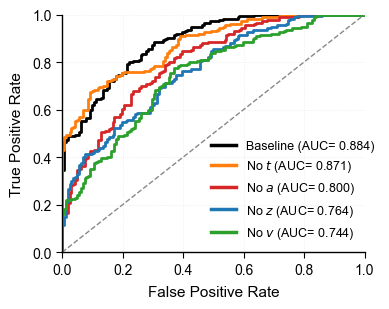

In [ ]:
import pickle
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from scipy.stats import false_discovery_control
import os

# Number of permutations for permutation test
N_PERMUTATIONS = 1000
RANDOM_SEED = 42

# Define correct feature set codes and descriptive names (do not swap mapping)
feature_sets = ['all', 'no_a', 'no_v', 'no_t', 'no_z']
feature_name_map = {
    'all':  'Baseline',
    'no_a': 'No $a$',
    'no_v': 'No $v$',
    'no_t': 'No $t$',
    'no_z': 'No $z$'
}

# Containers for results
results = []
roc_data = {}
y_true_dict = {}
y_prob_dict = {}

# Load each saved holdout prediction and compute metrics
np.random.seed(RANDOM_SEED)
for fs in feature_sets:
    pkl_path = f'metrics/{fs}_hold_metrics_list.pkl'
    if not os.path.isfile(pkl_path):
        raise FileNotFoundError(f"Metrics file not found: {pkl_path}")
    hold_list = pickle.load(open(pkl_path, 'rb'))
    y_true, y_prob = hold_list[0]
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    y_true_dict[fs] = y_true
    y_prob_dict[fs] = y_prob

    auc = roc_auc_score(y_true, y_prob)
    y_pred = (y_prob >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    bac = (sensitivity + specificity) / 2

    results.append({
        'fs': fs,
        'name': feature_name_map[fs],
        'auc': auc,
        'bac': bac,
        'sensitivity': sensitivity,
        'specificity': specificity
    })

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_data[fs] = (fpr, tpr)

# Sort by descending AUC
esults = sorted(results, key=lambda x: x['auc'], reverse=True)

# Print three-line table
line_top = "+--------------+-----------+-------+-------+-------+-------+"
header   = "| Feature Set  |   Name    |  AUC  |  BAC  | Sens  | Spec  |"
sep      = "+==============+===========+=======+=======+=======+=======+"
print(line_top)
print(header)
print(sep)
for row in results:
    print(f"| {row['fs']:<12} | {row['name']:<9} | {row['auc']:5.3f} | {row['bac']:5.3f} | {row['sensitivity']:5.3f} | {row['specificity']:5.3f} |")
print(line_top)

# Identify baseline fs
baseline_fs = next(r['fs'] for r in results if r['name']=='Baseline')
auc_baseline = next(r['auc'] for r in results if r['fs']==baseline_fs)
y_true_baseline = y_true_dict[baseline_fs]
y_prob_baseline = y_prob_dict[baseline_fs]

# Permutation test vs baseline
rng = np.random.RandomState(RANDOM_SEED)
perm_test_results = []
for row in results:
    fs = row['fs']
    if fs == baseline_fs: continue
    obs_diff = auc_baseline - row['auc']
    diffs = np.zeros(N_PERMUTATIONS)
    for i in range(N_PERMUTATIONS):
        perm = rng.permutation(y_true_baseline)
        diffs[i] = roc_auc_score(perm, y_prob_baseline) - roc_auc_score(perm, y_prob_dict[fs])
    p_val = (np.sum(diffs >= obs_diff) + 1) / (N_PERMUTATIONS + 1)
    perm_test_results.append({'fs': fs, 'name': feature_name_map[fs], 'obs_diff': obs_diff, 'p_value': p_val})

# FDR correction
pvals = [r['p_value'] for r in perm_test_results]
fdrs = false_discovery_control(pvals, method='bh')
for r, f in zip(perm_test_results, fdrs): r['fdr_p'] = f

# Print permutation results
perm_header = "+--------------+-----------+------------+-----------+-----------+"
perm_titles = "| Feature Set  |   Name    |  AUC Diff  |  P-value  | FDR P-val |"
perm_sep    = "+==============+===========+============+===========+===========+"
print("\n" + perm_header)
print(perm_titles)
print(perm_sep)
for r in perm_test_results:
    print(f"| {r['fs']:<12} | {r['name']:<9} | {r['obs_diff']:10.3f} | {r['p_value']:9.3f} | {r['fdr_p']:9.3f} |")
print(perm_header)

# ROC plotting
plt.rcParams.update({
    'figure.figsize': (4,3.2), 'font.family': 'sans-serif',
    'font.sans-serif': ['Arial','Helvetica'], 'font.size': 10,
    'axes.linewidth':1.0,'legend.frameon':False,'lines.linewidth':2.0
})
fig, ax = plt.subplots()
colors = {'all':'#d62728','no_a':'#1f77b4','no_v':'#ff7f0e','no_t':'#2ca02c','no_z':'#000000'}
for r in results:
    fpr, tpr = roc_data[r['fs']]
    ax.plot(fpr, tpr, color=colors[r['fs']], label=f"{r['name']} (AUC={r['auc']:.3f})")
ax.plot([0,1],[0,1],linestyle='--',color='#888',linewidth=1)
ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.grid(color='#ddd',linestyle=':',linewidth=0.5,alpha=0.7)
ax.legend(loc='lower right',frameon=False,fontsize=9,bbox_to_anchor=(1.07,0))
plt.tight_layout()
plt.savefig('roc_curves_nature_style_fdr.png',dpi=800,bbox_inches='tight')
plt.show()
